## COMPARE datasets extracted via SQL and by the new rasterstats method

In [1]:
import pylab as plt
import pandas as pd
import numpy as np

In [2]:
%%time
# MODIS ET
et = pd.read_csv("../SQL/drought_consultas_br_et.csv").pivot_table(index="acquisition",
                   columns="geocodig_m",values="mean").interpolate()

# MODIS LAI
lai = pd.read_csv("../SQL/drought_consultas_br_lai.csv").pivot_table(index="acquisition",
                   columns="geocodig_m",values="mean").interpolate()

#FILTERED NDVI
ndvi = pd.read_csv("../SQL/drought_consultas_br_ndvi.csv").pivot_table(index="acquisition",
                   columns="geocodig_m",values="mean").interpolate()
#LST
lstd = pd.read_csv("../SQL/drought_consultas_br_lst_day.csv").pivot_table(index="acquisition",
                   columns="geocodig_m",values="mean").interpolate() * 0.02 - 273.15
lstn = pd.read_csv("../SQL/drought_consultas_br_lst_night.csv").pivot_table(index="acquisition",
                   columns="geocodig_m",values="mean").interpolate() * 0.02 - 273.15

# ESI
esi = pd.read_csv("../SQL/drought_consultas_br_esi.csv").pivot_table(index="acquisition",
                   columns="geocodig_m",values="mean").interpolate()

esir = pd.read_csv("../SQL/drought_consultas_br_esi_regioes.csv").pivot_table(index="acquisition",
                   columns="subgrupo2",values="mean").interpolate()

esirc = pd.read_csv("../SQL/drought_consultas_br_esi_regioes_crop.csv").pivot_table(index="acquisition",
                   columns="subgrupo2",values="mean").interpolate()

# PREC CHIRPS

zprec = pd.read_csv("../SQL/drought_consultas_br_sul_chirps_zscore.csv").pivot_table(index="acquisition",
                   columns="geocodig_m",values="mean").interpolate()

prec = pd.read_csv("../SQL/drought_consultas_br_sul_chirps_prec.csv").pivot_table(index="acquisition",
                   columns="geocodig_m",values="mean").interpolate()


# GLEAM SM Root abs
smrootabs = pd.read_csv("../SQL/drought_consultas_br_sm_root_abs_region.csv").pivot_table(index="acquisition",
                   columns="subgrupo2",values="mean").interpolate()

# GLEAM SM Root anom
smrootanom = pd.read_csv("../SQL/drought_consultas_br_sm_root_anom_region.csv").pivot_table(index="acquisition",
                   columns="subgrupo2",values="mean").interpolate()

# GLEAM SM surface abs
smsurfabs = pd.read_csv("../SQL/drought_consultas_br_sm_surf_abs_region.csv").pivot_table(index="acquisition",
                   columns="subgrupo2",values="mean").interpolate()

# GLEAM SM surface anom
smsurfanom = pd.read_csv("../SQL/drought_consultas_br_sm_surf_anom_region.csv").pivot_table(index="acquisition",
                   columns="subgrupo2",values="mean").interpolate()


smrootabs.index = pd.DatetimeIndex(smrootabs.index)
smrootanom.index = pd.DatetimeIndex(smrootanom.index)
smsurfabs.index = pd.DatetimeIndex(smsurfabs.index)
smsurfanom.index = pd.DatetimeIndex(smsurfanom.index)
esir.index = pd.DatetimeIndex(esir.index)
esirc.index = pd.DatetimeIndex(esirc.index)

#CROP AREAS  
aux = pd.read_csv("../SQL/drought_consultas_br_aux_big_sul_crop.csv")

# LIST OF MUNICIPALITIES, MESO, MICROregions
sulmuni = pd.read_csv("../SQL/sul_muni.csv")
sulmuni.drop(["sigla","nome_muni","muni"],axis=1,inplace=True)

CPU times: user 7.13 s, sys: 345 ms, total: 7.48 s
Wall time: 10.9 s


In [7]:
def piv_table(var,lista,resample='M'):
    region_var = weightaverage(var,lista)
    region_var = pd.DataFrame(region_var)
    region_var.columns = ['values']
    region_var = region_var.resample('M').mean()

    region_var['year'] = region_var.index.year
    region_var['month'] = region_var.index.month
    region_var_piv = region_var.pivot(index='year', columns='month', values='values')
    region_var_piv.columns = month_names
    return region_var_piv

def weightaverage(var,region_number,area):
    '''
        var (pandas DataFrame): dataset containing the variable, either extracted from SQL or CSV, or the z-score of it
        region_number (int): group number (from grouped, in this case)
        area (float): threshold for minimum area to be considered for a municipality to be included in the weight average
    '''

    #area threshold -> I HAVE TO VERIFY WHAT THESE AREAS MEAN IN THE MAP

    l = list(aux[(aux['microrregi'].isin(grouped[region_number])) & (aux['area']> area)].geocodig_m)
    a = aux[aux['geocodig_m'].isin(l)]
    a['w'] = a.area/sum(a.area)
    a = a[['geocodig_m','w']]
    a.index = a.geocodig_m
    a.drop("geocodig_m",inplace=True,axis=1)
    a = a.T
    var_aw = pd.DataFrame(var[a.columns].values*a.values, columns=a.columns,index=var[a.columns].index)
    var_final = var_aw.sum(axis=1,skipna=True)
    var_final.index = pd.DatetimeIndex(var_final.index)
    print('A total of %d municipalities were considered' %var_aw.shape[1])
    return(var_final)

# CONVERTING Municipals to regionals
def grouping(var,thresh=15000):
    globals()['{}r'.format(var)] = pd.DataFrame()
    for i,j in enumerate(groupnames):
        globals()['{}r'.format(var)][j] = weightaverage(var,i,thresh)
    return globals()['{}r'.format(var)]

In [4]:
# REMEMBER TO COMPARE THIS GROUPS WITH THE HCC GROUPS
regions = [41004, 41005, 41007, 41008, 41009, 41010, 41011, 41012, 41013, 41014, 41015, 41019, 
           41020, 41021, 41022, 41023, 41024, 41027, 41028, 41029, 41030, 42003, 43005,  43008, 
           43009, 43010, 43011, 43012, 43017]

grouped = [[41019,41020, 41021], #ce-PR
           [41007, 41008, 41009, 41010, 41011, 41012, 41013, 41014, 41015], #cn-PR
           [41004, 41005,41022, 41023, 41024], #cw-PR
           [41027, 41028, 41029, 41030, 42003], #sw-PR
           [43005,  43008,43009, 43010, 43011, 43012, 43017]] #nw-RS

groupnames = ['ce-PR', 'cn-PR', 'cw-PR', 'nw-RS', 'sw-PR']

In [6]:
#MERGING data: aux with soy_null occurrence... kinda useless
aux = pd.merge(aux, sulmuni[["soy_null","geocodig_m"]], on='geocodig_m')
aux = aux[aux["soy_null"]<1].drop("soy_null",axis=1)

In [25]:
#IMPORT the new datasets
nesi = pd.read_csv("../SQL/tables/esi04_mean.csv")
nlai = pd.read_csv("../SQL/tables/LAI_filt_anom_mean.csv")
nndvi = pd.read_csv("../SQL/tables/NDVI_filt_mean.csv")
net = pd.read_csv("../SQL/tables/ET_raw_mean.csv")

In [29]:
#NDVI
ndvi = pd.read_csv("../SQL/drought_consultas_br_ndvi.csv").pivot_table(index="acquisition",
                   columns="geocodig_m",values="mean")
ndvir = grouping(ndvi,thresh=1000)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


A total of 175 municipalities were considered
A total of 227 municipalities were considered
A total of 202 municipalities were considered
A total of 111 municipalities were considered
A total of 92 municipalities were considered


In [24]:
ndvir.head()

,ce-PR,cn-PR,cw-PR,nw-RS,sw-PR
acquisition,,,,,
2001-01-09,7343.464413,7814.465251,8098.856590,7197.526749,7316.725649
2001-01-17,7063.191287,7689.392325,7765.822043,7085.456492,7610.990145
2001-01-25,6705.382388,7316.567068,7427.031102,6998.950690,7848.208882
2001-02-02,6694.102930,7246.376688,7344.495725,7099.859152,7730.000387
2001-02-10,6588.398660,7002.735824,6920.823586,7002.935001,7777.067327


In [26]:
nndvi.index = nndvi['date']
nndvi.head()

,date,cn-PR,nw-RS,cw-PR,ce-PR,sw-PR
date,,,,,,
2001-01-09,2001-01-09,7230.853337,7211.433972,7485.149561,7252.302495,7072.246472
2001-01-17,2001-01-17,7091.054858,7410.923954,7248.956480,6864.882227,6824.474713
2001-01-25,2001-01-25,6806.114256,7593.439568,7030.091530,6398.777501,6687.124700
2001-02-02,2001-02-02,6828.007839,7524.961771,7139.078858,6451.796808,6834.849203
2001-02-10,2001-02-10,6778.111655,7584.393149,6920.672000,6475.885422,6844.712583


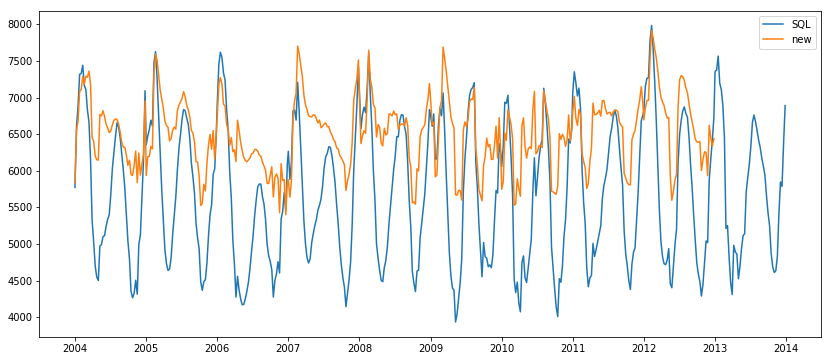

In [30]:
plt.figure(figsize=(14,6))
plt.plot(ndvir['ce-PR'].loc["2004":"2013"],label='SQL')
plt.plot(nndvi['ce-PR'].loc["2004":"2013"],label='new')
plt.legend();plt.show()

In [35]:
#ET
et = pd.read_csv("../SQL/drought_consultas_br_et.csv").pivot_table(index="acquisition",
                   columns="geocodig_m",values="mean")#.interpolate()


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


A total of 175 municipalities were considered
A total of 250 municipalities were considered
A total of 208 municipalities were considered
A total of 114 municipalities were considered
A total of 95 municipalities were considered


In [40]:
etr = grouping(et,thresh=18000)
net.index = net['date']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


A total of 44 municipalities were considered
A total of 28 municipalities were considered
A total of 77 municipalities were considered
A total of 42 municipalities were considered
A total of 48 municipalities were considered


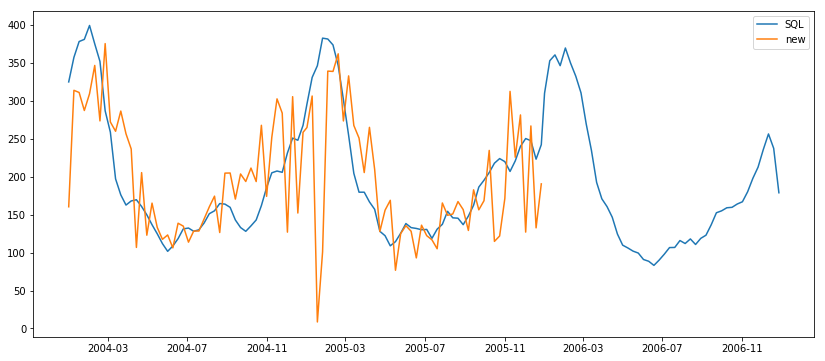

In [45]:
plt.figure(figsize=(14,6))
plt.plot(etr['ce-PR'].loc["2004":"2006"],label='SQL')
plt.plot(net['ce-PR'].loc["2004":"2006"].rolling(1).mean(),label='new')
plt.legend();plt.show()

### Simple plots

In [82]:
df = pd.read_excel("../tabular/Area_yield_Soja_milho_RS_PR.xlsx",sheet_name='resumo')

df.index = df.Year

df2 = df[['Y_Soybean (PR)','Y_Soybean (RS)','A_Soybean (PR)','A_Soybean (RS)']]

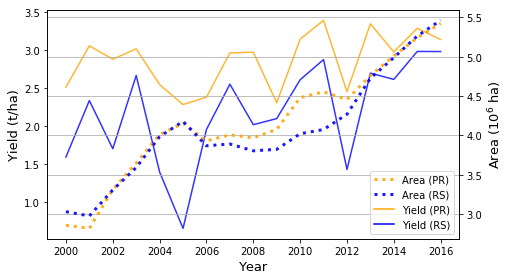

In [83]:
fig, ax1 = plt.subplots(figsize=(7.2,4))

ax1.set_xlabel('Year',fontsize=13)
ax1.set_ylabel('Yield (t/ha)',fontsize=13)
ax1.plot(df2['Y_Soybean (PR)']/1000, label= 'Yield (PR)', alpha=0.8, color = 'orange')
ax1.plot(df2['Y_Soybean (RS)']/1000, label= 'Yield (RS)', alpha=0.8, color = 'blue')


#ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_ylabel(r'Area ($10^6$ ha)',fontsize=13)
ax2.plot(df2['A_Soybean (PR)']/1e6, ':',label='Area (PR)', lw=3, alpha=0.9, color = 'orange')
ax2.plot(df2['A_Soybean (RS)']/1e6, ':', label='Area (RS)', lw=3, alpha=0.9, color = 'blue')
ax2.plot(np.nan, '-r', label= 'Yield (PR)', color = 'orange')
ax2.plot(np.nan, '-r', label= 'Yield (RS)', color = 'blue')

ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid();plt.legend(loc='lower right')
plt.savefig('../document/images/yield_area.pdf', bbox_inches='tight');plt.show()

In [2]:
# GLEAM SM surface abs
swdiroot = pd.read_csv("../SQL/drought_consultas_br_swdi_root_abs_region.csv").pivot_table(index="acquisition",
                   columns="subgrupo2",values="mean").interpolate()

# GLEAM SM surface anom
swdisurf = pd.read_csv("../SQL/drought_consultas_br_swdi_surface_abs_region.csv").pivot_table(index="acquisition",
                   columns="subgrupo2",values="mean").interpolate()

In [7]:
swdisurf.index = pd.DatetimeIndex(swdisurf.index)
swdiroot.index = pd.DatetimeIndex(swdiroot.index)

In [10]:
swdiroot.head()

subgrupo2,ce-PR,cn-PR,cw-PR,nw-RS,sw-PR
acquisition,,,,,
2003-01-01,-1.927516,-2.409415,-1.685192,-1.488428,-1.502550
2003-01-08,-1.993650,-2.201952,-2.056727,-1.811357,-2.387899
2003-01-15,-2.598213,-2.937327,-2.748944,-2.425417,-3.279533
2003-01-22,-1.810939,-1.466049,-1.841614,-2.183712,-2.894372
2003-01-29,-0.841925,-0.704185,-2.715800,-3.888641,-3.916450


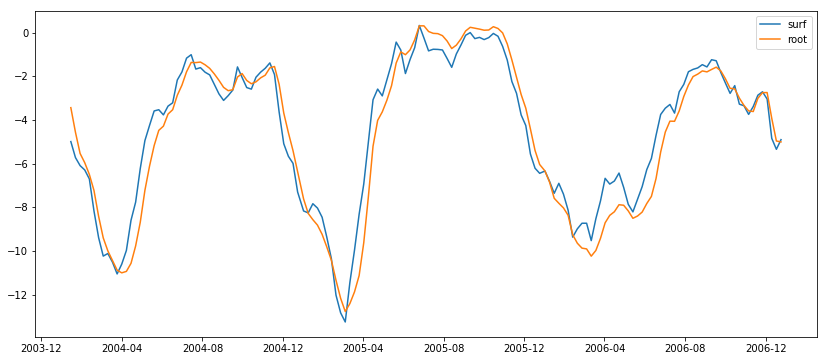

In [18]:
plt.figure(figsize=(14,6))
plt.plot(swdisurf['nw-RS'].loc["2004":"2006"].rolling(3).mean(),label='surf')
plt.plot(swdiroot['nw-RS'].loc["2004":"2006"].rolling(3).mean(),label='root')
plt.legend();plt.show()